In [34]:
import pandas as pd
import requests
import os, json
from json import JSONDecodeError
import math
import random
import numpy as np
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import matplotlib

In [2]:
def get_json(from_year, to_year):
    if not 2000 < int(from_year) < 2050 or not 2000 < int(from_year) < 2050:
        return []
    all_holidays = []
    for i in range(from_year, to_year+1):
        r = requests.get(f'https://date.nager.at/api/v2/publicholidays/{i}/CH')
        all_holidays.extend(r.json())
    return all_holidays

def set_date_index(df, col='date'):
    return df.set_index(pd.to_datetime(df[col])).drop(col, axis=1)

def filter_canton(df, can='BS'):
    return df[[(str('CH-' + can) in row) if row is not None else True for row in df.counties]]

def get_holiday_data(canton='BS', from_year=2015, to_year=2019):
    holiday_data = get_json(from_year, to_year)
    holiday_df = (pd.DataFrame.from_records(holiday_data)
                  .pipe(set_date_index)
                  .pipe(filter_canton, can=canton))
    return holiday_df

In [3]:
# 105: Basel
def import_weather_data(station_index=105):    
    stationdata = []
    station_error = 0

    for root, dirs, files in os.walk("weather_data/2018"):
        for file in files: 
            if not file.endswith(".json"): continue
            filename = os.path.join(root, file)
            try:
                with open(filename) as json_file:
                    data = json.load(json_file)
                    stationdata.append(data[station_index])
            except UnicodeDecodeError:
                station_error = station_error + 1
            except JSONDecodeError:
                station_error = station_error + 1
    print ("Loaded: %d - errors: %d" % (len(stationdata), station_error))
    pandata = pd.DataFrame(stationdata)
    pandata = pandata.drop(columns=['code','station'])
    return pandata

def clean_weather_data(weather_df): 
    weather_df['temperature'] = pd.to_numeric(weather_df['temperature'])
    weather_df['sunshine'] = pd.to_numeric(weather_df['sunshine'])
    weather_df['precipitation'] = pd.to_numeric(weather_df['precipitation'])
    return weather_df.set_index(pd.to_datetime(weather_df['dateTime'])).drop('dateTime', axis=1).sort_index()

def get_weather_score():
    weather_data = (import_weather_data()
                    .pipe(clean_weather_data))
    # first version, just take sunshine value
    return weather_data[['sunshine']]

def get_metheo_weather():
    metheo = pd.read_csv('raw_data/metheo.csv', delimiter=';')
    metheo['Date'] = pd.to_datetime(metheo[['Year','Month','Day','Hour','Minute']])
    metheo = metheo.drop(['Year','Month','Day','Hour','Minute'], axis=1).set_index('Date')
    metheo['SWR'] = metheo.pop('Shortwave Radiation')
    return metheo

def get_basel_kanton_weather():
    basel_wetter = pd.read_csv('raw_data/100051.csv', delimiter=';', parse_dates=True)
    basel_wetter.set_index(pd.to_datetime(basel_wetter['Datum/Zeit'])).drop('Datum/Zeit', axis=1).sort_index().dropna()
    return basel_wetter

In [4]:
def import_basel_data():
    data = pd.read_csv("raw_data/Basel_Daten.csv", delimiter=';')
    stamps = [x.split('+')[0] for x in data['DateTimeFrom'].values]
    data = data.assign(Time=pd.to_datetime(stamps.copy(), format="%Y-%m-%dT%H:%M:%S"))
    return data

def clean_location_data(location_df):
    location_df = location_df.set_index('Time')
    location_df = location_df.assign(Day=location_df.index.day)
    return location_df

def get_location_data(df, location):
    mask = df['SiteName'] == location
    return df[mask], df[~mask]

def get_group_data(df, group):
    mask = df['Group'] == group
    return df[mask], df[~mask]

def get_location_split_dict(data):
    location_dict = {}
    #Alle Orte
    locs = sorted(list(set(data['SiteName'])))
    for loc in locs:
        location_df, data = get_location_data(data, loc)
        location_dict[loc] = clean_location_data(location_df)
    return location_dict

def get_group_split_dict(data):
    group_dict = {}
    location_group = {'350 Dreirosenbrücke': 3, '352 Johanniterbrücke': 3, '354 Wettsteinbrücke': 3,
                      '403 Heuwaage-Viadukt': 3, '405 Dorenbachviadukt': 2, '659 Schlachthofstrasse': 3,
                      '660 Flughafenstrasse': 3, '802 Klybeckstrasse 113/Kirche': 1, '803 Johanniterbrücke': 1,
                      '804 Rosentalstrasse 29/28': 2, '805 Rebgasse 11/28': 1, '806 Gerbergasse': 1,
                      '807 Güterstrasse 180/183': 1, '808 Wolfschlucht-Promenade': 1, '809 Allschwilerstrasse 77/86': 1,
                      '810 Neubadstrasse 124/137': 1, '811 Mülhauserstrasse 110/122': 1, '812 Wettsteinbrücke': 1,
                      '813 Hardstrasse 66/77': 1, '814 Elisabethenstrasse 46*': 1, '815 Mittlere Rheinbrücke': 1,
                      '816 Schmiedgasse 4/7 (Riehen)': 1, '817 Elisabethenanlage': 1, '901 Peter-Merian Weg': 3,
                      '902 Viaduktstrasse': 3, '903 Äussere Baselstrasse 328': 2, '904 Hammerstrasse 90': 2,
                      '905 Leimenstrasse 4': 2, '906 Hegenheimerstrasse 44': 2, '907 Wasgenring 62': 2,
                      '908 Grenzacherstrasse (Kraftwerk)': 2, '909 General Guisan-Strasse 104': 2,
                      '910 St. Galler-Ring 101': 2, '911 Birskopfsteg': 2, '912 Elsässerstrasse 261/260': 2,
                      '913 Burgfelderstrasse': 3, '914 Hiltalingerstrasse': 1, '915 Luzernerring-Brücke': 3,
                      '916 Stückisteg': 1, '917 Schwarzwaldbrücke': 3, '918 Elsässerrheinweg': 0,
                      '919 St. Alban-Rheinweg': 2, '920 J. Burckhardt-Strasse': 3}
    data['Group'] = data['SiteName'].apply(lambda x: location_group[x])
    for group in range(4):
        group_df, data = get_group_data(data, group)
        group_df = group_df.assign(Day=group_df['Time'].dt.day)
        group_dict[group] = group_df
    return group_dict

#TODO CREATE REAL SAMPLES
def resample_location_data(location_df, frequency):
    if frequency == 'D':
        cols = ['Total']
    elif frequency == 'H':
        cols = ['Total', 'Month', 'Day', 'Holiday', 'Weekday', 'HourFrom', 'Temperature', 'Precipitation', 'SWR']
    else:
        print("INCORRECT FREQUENCY")
    location_df = location_df[cols].resample(frequency).sum()
    return location_df

def cyclical_encoding(x, m, f):
    return f(2*math.pi*x/m)

def create_classification_samples(data, group):
    cols = ['Total', 'Month', 'Day', 'Holiday', 'Weekday', 'HourFrom', 'Temperature', 'Precipitation', 'SWR', 'SiteName', 'Time']
    data = data[cols]
    data['SinMonth'] = data['Month'].apply(cyclical_encoding, m=12, f=math.sin)
    data['CosMonth'] = data['Month'].apply(cyclical_encoding, m=12, f=math.cos)
    data['SinDay'] = data['Day'].apply(cyclical_encoding, m=30, f=math.sin)
    data['CosDay'] = data['Day'].apply(cyclical_encoding, m=30, f=math.cos)
    data['SinWeekday'] = data['Weekday'].apply(cyclical_encoding, m=7, f=math.sin)
    data['CosWeekday'] = data['Weekday'].apply(cyclical_encoding, m=7, f=math.cos)
    #data['SinHour'] = data['Hour'].apply(cyclical_encoding, m=24, f=math.sin)
    #data['CosHour'] = data['Hour'].apply(cyclical_encoding, m=24, f=math.cos)
    data = data.drop(['Month', 'Day', 'Weekday'], axis=1)
    X_train = []
    X_test = []
    X = data[data['HourFrom'].isin([7, 12, 15])]
    for loc in list(set(X['SiteName'])):
        loc_mask = X['SiteName'] == loc
        for day in list(set(X['Time'].dt.date)):
            day_mask = X['Time'].dt.date == day
            full_mask = (loc_mask) & (day_mask)
            samples = X[full_mask]
            #print(samples)
            X = X[~full_mask]
            X_filtered = samples[['Total', 'SinMonth', 'CosMonth', 'SinDay', 'CosDay', 'SinWeekday', 'CosWeekday',
                                  'Holiday', 'Precipitation', 'SWR']]
            total_sum = X_filtered['Total'].sum()
            X_filtered['Total'] = X_filtered['Total'] / total_sum
            #print(X_filtered)
            #print(X_filtered.values)
            if not X_filtered.empty:
                if random.random() > 0.75:
                    X_test.append(X_filtered.values)
                else:
                    X_train.append(X_filtered.values)
    y_train = [group] * len(X_train)
    y_test = [group] * len(X_test)
    return X_train, X_test, y_train, y_test
    
    

In [70]:
%matplotlib inline

def location_plot(plotdata, show=0, ax2=None, rain=False):

    data_by_day = {"%d:%d"%(mk,dk):dv.sort_values(by=['HourFrom']) for mk, mv in plotdata.groupby('Month')
                                                                         for dk, dv in mv.groupby('Day')}

    if show == 2:
        fig, ax = plt.subplots(4,2, figsize=(10,13))
        #Flatten
        ax = [x for y in ax for x in y]
    mean = np.zeros((7,24))
    numb = np.array(7*[0])
    
    for i in range(1, len(data_by_day)):
        vals = list(data_by_day.values())[i]
        thisday = vals['Weekday'].values[0]
        if len(vals['Weekday'].values) == 24:
            numb[thisday] += 1
            mean[thisday,:] += np.array(list(data_by_day.values())[i]['Total'].values)
            if show == 2:
                if not rain:
                    ax[thisday].plot(list(data_by_day.values())[i]['Total'].values, alpha=0.3, c='blue')
                else:
                    cmap = plt.cm.cividis
                    ax[thisday].plot(list(data_by_day.values())[i]['Total'].values, alpha=0.3, c=cmap(100*np.mean(list(vals['Precipitation'].values))))

    mean = mean/np.reshape(numb,(7,1))
    if show >= 1:
        showLater = True
        if ax2==None:
            showLater = False
            fig, ax2 = plt.subplots(figsize=(10,8))
        cs=5*['blue']+['orange']+['red']
        for i in range(7):
            ax2.plot(mean[i], c=cs[i])
        if not showLater:
            ax2.legend(['Montag', 'Dienstag', 'Mittwoch', 'Donnerstag', 'Freitag', 'Samstag', 'Sonntag'])
            plt.show()
    
    return mean

In [22]:
holiday_df = get_holiday_data()
#weather_data = (import_weather_data()
#                .pipe(clean_weather_data))[['sunshine', 'precipitation', 'temperature']]
metheo = get_metheo_weather()
data = import_basel_data()
data = data.drop('SiteCode', axis=1)
data['Holiday'] = [1 if x in holiday_df.index else 0 for x in data['Time']]
data = pd.merge(data, metheo, left_on='Time', right_index=True).dropna()

In [23]:
def justus_filter(data, location):
    cols = ['Total', 'Month', 'Day', 'Holiday', 'Weekday', 'HourFrom', 'Temperature', 'Precipitation', 'SWR', 'SiteName', 'Time']
    data = data[cols]
    data = data[data['SiteName'] == location].set_index('Time')
    return data

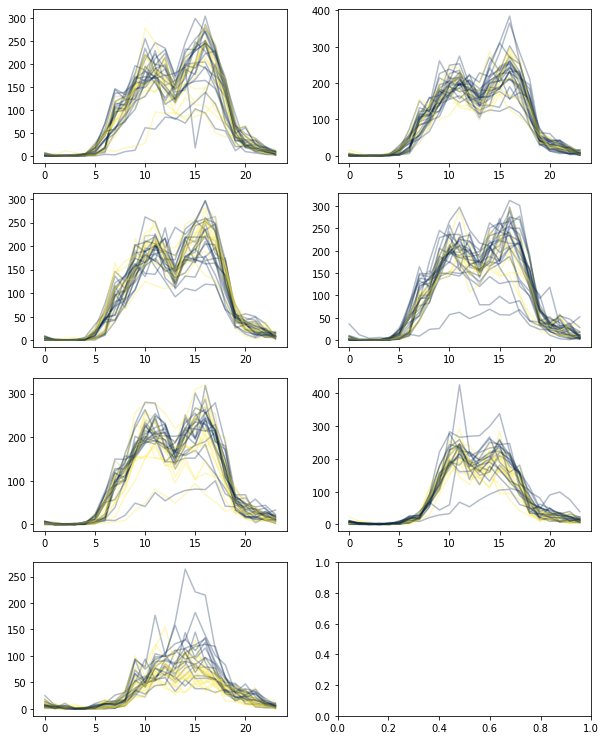

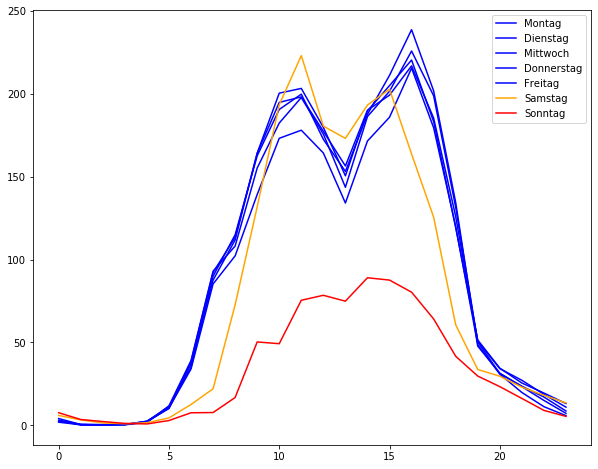

array([[1.91428571e+00, 3.71428571e-01, 4.57142857e-01, 6.00000000e-01,
        2.08571429e+00, 1.04571429e+01, 3.40285714e+01, 8.52857143e+01,
        1.02228571e+02, 1.39257143e+02, 1.73142857e+02, 1.78028571e+02,
        1.64285714e+02, 1.34114286e+02, 1.71514286e+02, 1.85857143e+02,
        2.15485714e+02, 1.79514286e+02, 1.19971429e+02, 4.86857143e+01,
        3.08857143e+01, 1.98571429e+01, 1.12857143e+01, 5.88571429e+00],
       [2.57142857e+00, 5.42857143e-01, 4.00000000e-01, 5.42857143e-01,
        2.48571429e+00, 1.12857143e+01, 3.48285714e+01, 8.99714286e+01,
        1.14971429e+02, 1.62571429e+02, 1.90542857e+02, 1.99771429e+02,
        1.72542857e+02, 1.53171429e+02, 1.87628571e+02, 2.11114286e+02,
        2.38657143e+02, 2.01771429e+02, 1.34457143e+02, 4.78000000e+01,
        3.14857143e+01, 2.33714286e+01, 1.50571429e+01, 7.25714286e+00],
       [2.67647059e+00, 2.64705882e-01, 2.05882353e-01, 3.52941176e-01,
        1.82352941e+00, 1.17941176e+01, 3.90882353e+01, 9.2970

In [73]:
dat = justus_filter(data, '816 Schmiedgasse 4/7 (Riehen)')
location_plot(dat, show=2, rain = True)

In [ ]:
X_c_train, X_c_test, y_c_train, y_c_test = [], [], [], []
for group, group_data in get_group_split_dict(data).items():
    X_train, X_test, y_train, y_test = create_classification_samples(group_data.copy(), group)
    X_c_train.extend(X_train)
    X_c_test.extend(X_test)
    y_c_train.extend(y_train)
    y_c_test.extend(y_test)

In [ ]:
Input_train = [x.reshape(30) for x in X_c_train]
Input_test = [x.reshape(30) for x in X_c_test]
Input_train = np.array(Input_train)
Input_test = np.array(Input_test)
y_c_train = np.array(y_c_train)
y_c_test = np.array(y_c_test)

In [ ]:
from xgboost import XGBClassifier
model = XGBClassifier()
model.fit(Input_train, y_c_train)

In [ ]:
y_pred = model.predict(Input_test)
predictions = [round(value) for value in y_pred]

In [ ]:
y_pred

In [ ]:
y_c_test

In [ ]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_c_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))